In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json # to read credentials

# SQL stuff
#import psycopg2 as ps
#import pandas.io.sql as sqlio
#from sqlalchemy import create_engine
#from sqlalchemy.types import Integer, Text, String, DateTime
#engine = create_engine('sqlite://', echo=False)
#from pyspark.sql.functions import size,col

# TRINO stuff
import trino

# Regex stuff
import re

# PDF stuff
import PyPDF2 as pypdf

# Dates stuff
from datetime import datetime, date, timedelta

# GSheet Stuff
from gspread_pandas import Spread

# Computer Stuff
import os

# Dates stuff
from datetime import datetime, date, timedelta

import pathlib
from mizani.breaks import date_breaks

# Operating system stuff
#import pathlib 

# Plot stuff
import plotnine as pn

# Statistics stuff + DS stuff
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

# Statistics Stuff
from statsmodels.stats.proportion import proportion_confint, test_proportions_2indep, proportion_effectsize

pd.set_option('display.max_columns', None)

In [2]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [3]:
start_date='2024-08-19'
end_date='2024-08-26' # date of the run

In [4]:
#old query
query= f'''
SELECT DATE(DATE_TRUNC('MONTH', rfs.p_creation_date)) AS date
        , CASE 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 1 THEN 'NC' 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) > 1 AND CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) < 5 THEN 'TC' 
        ELSE 'EC' END AS customer_type
        , rfs.risk_feature_snapshot_creation_datetime AS rfs_creation_date
        , rfs.risk_feature_snapshot_id AS id
        , rfs.customer_id
        , json_extract_scalar(rfs.features, '$.order.countryCode') AS order_country
        , json_extract_scalar(rfs.features, '$.customer.ordersCount') AS ordersCount
        , json_extract_scalar(rfs.features, '$.customer.debtOrdersCount') AS debtOrdersCount 
        , JSON_EXTRACT_SCALAR(rfs.features, '$.ml.ml_ca.score')             AS cash_arrears_score
        --, json_extract_scalar(rfs.features, '$.ml.ml_uch.score')             AS cash_unpaid_score 
        , JSON_EXTRACT_SCALAR(rfs.features, '$.order.amountInEur.amountMajor')   AS order_amount_eur
        , JSON_EXTRACT_SCALAR(rfs.features, '$.customer.debtTotalInEur')         AS debt_amount_eur

        -- CHECKOUT 
        , co.checkout_status

          -- RULE TRIGGERS
        --, rd.risk_decision_creation_datetime
        --, rd.decision_id
        --, rd.risk_decision_id
        --, row_number() over (PARTITION BY rd.decision_id  order by rd.risk_decision_id asc) as first_rule_trigger -- security_check
        --, row_number() over (PARTITION BY rd.decision_id  order by rd.risk_decision_id desc) as last_rule_trigger -- security_check
        --, rd.rule
               --, rd.risk_decision_is_shadowing
        --, rd.executed_actions
        
        -- ORDERS 
        , o.order_created_at AS order_creation_date 
        , o.order_country_code
        , o.order_id
        , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
        , o.order_cancel_reason
        , o.order_total_purchase_eur AS gmv_euros
        
        -- PAYMENTS
        , p.payment_status
        , p.payment_method
        , p.payment_forgiven
        , round(round(abs(p.balance) / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_balance_eur
        , round(round(p.amount_paid / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_amount_paid_eur--variable--p_amount_paid_eur
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
        --, COUNT(DISTINCT rfs.checkout_id) AS attempts
        --, COUNT(DISTINCT rfs.customer_id) AS customer_attempts
FROM (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced WHERE TRUE AND checkpoint = 'checkout' AND crc32(cast ('arrears-cg' || cast(customer_id as varchar) as varbinary)) < (0.05 * 4294967295)  AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') AND CAST(json_extract_scalar(features, '$.customer.debtOrdersCount') AS INT)>0 AND json_extract_scalar(features, '$.payment_method.type')='CASH') rfs
    --LEFT JOIN (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_decisions WHERE TRUE AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') --AND executed_actions='ALLOW_BALANCED_ORDER' 
      --          AND risk_decision_is_shadowing = False) rd ON rd.decision_id=rfs.decision_id
    --LEFT JOIN sensitive_delta.central_checkout_orders_odp.checkout_orders co      ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN sensitive_delta.sensitive_fintech__checkout_orders__odp.checkout_orders co ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2                 o ON o.order_id = co.order_id AND DATE(o.p_creation_date)>=DATE('{start_date}') AND DATE(o.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.fintech_payments_odp.payments                                      p ON p.order_id = o.order_id AND DATE(p.p_creation_date)>=DATE('{start_date}') AND DATE(p.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level                     cm ON cm.order_id=o.order_id AND DATE(cm.p_creation_date)>=DATE('{start_date}') AND DATE(cm.p_creation_date)<DATE('{end_date}')  


'''

In [5]:
#new query
query= f'''
SELECT DATE(DATE_TRUNC('day', rfs.p_creation_date)) AS date
        , CASE 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 1 THEN 'NC' 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) > 1 AND CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) < 5 THEN 'TC' 
        ELSE 'EC' END AS customer_type
        , rfs.risk_feature_snapshot_creation_datetime AS rfs_creation_date
        , rfs.risk_feature_snapshot_id AS id
        , rfs.customer_id
        , json_extract_scalar(rfs.features, '$.order.countryCode') AS order_country
        , json_extract_scalar(rfs.features, '$.customer.ordersCount') AS ordersCount
        , json_extract_scalar(rfs.features, '$.customer.debtOrdersCount') AS debtOrdersCount 
        
        , JSON_EXTRACT_SCALAR(rfs.features, '$.order.amountInEur.amountMajor')   AS order_amount_eur
        , JSON_EXTRACT_SCALAR(rfs.features, '$.customer.debtTotalInEur')         AS debt_amount_eur
        
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_ca.score'), ' ') AS production_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_ca.shadowing.ml_ca_v0.score'),' ') AS shadowing_score
        

        -- CHECKOUT 
        , co.checkout_status
        
        -- ORDERS 
        , o.order_created_at AS order_creation_date 
        , o.order_country_code
        , o.order_id
        , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
        , o.order_cancel_reason
        , o.order_total_purchase_eur AS gmv_euros
        
        -- PAYMENTS
        , p.payment_status
        , p.payment_method
        , p.payment_forgiven
        , round(round(abs(p.balance) / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_balance_eur
        , round(round(p.amount_paid / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_amount_paid_eur
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced WHERE TRUE 
            AND checkpoint = 'checkout' 
            AND crc32(cast ('arrears-cg' || cast(customer_id as varchar) as varbinary)) < (0.05 * 4294967295) 
            AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') 
            AND CAST(json_extract_scalar(features, '$.customer.debtOrdersCount') AS INT)>0 
            AND json_extract_scalar(features, '$.payment_method.type')='CASH'
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_ca.shadowing.ml_ca_v0.score'),' ') IS NOT NULL
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_ca.score'), ' ') IS NOT NULL
    ) rfs
    LEFT JOIN sensitive_delta.sensitive_fintech__checkout_orders__odp.checkout_orders co ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2                 o ON o.order_id = co.order_id AND DATE(o.p_creation_date)>=DATE('{start_date}') AND DATE(o.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.fintech_payments_odp.payments                                      p ON p.order_id = o.order_id AND DATE(p.p_creation_date)>=DATE('{start_date}') AND DATE(p.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level                     cm ON cm.order_id=o.order_id AND DATE(cm.p_creation_date)>=DATE('{start_date}') AND DATE(cm.p_creation_date)<DATE('{end_date}')  


'''


In [6]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1346933151.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


# Function definitions

In [7]:
def calculate_percentiles(df, target_column='target'):
    # Initialize an empty list to store the percentile data
    percentiles_list = []
    
    # Define the percentiles you want to calculate
    percentile_ranks = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 95, 96, 97, 98, 99, 100]
    percentile_names = ['0th', '1st', '5th', '10th', '20th', '30th', '40th', '50th', '60th', '70th','75th', '80th', '90th', '95th','96th', '97th','98th', '99th', '100th']
    
    # Calculate the percentiles for the target column
    target_data = df[target_column]
    percentiles = np.nanpercentile(target_data, percentile_ranks)
    
    percentiles_list = list(percentiles) if isinstance(percentiles, np.ndarray) else [percentiles]
    
    # Create a DataFrame from the list with percentiles
    df_percentiles = pd.DataFrame([percentiles_list], columns=percentile_names)
    
    return df_percentiles

In [8]:
def plot_roc_curve(df, preds_col=None, label_col=None):

    # Create a copy of the predicted probabilities column and normalize it
    preds_normalized = df[preds_col] / 100.0

    # Create the ROC curve
    fpr, tpr, thresholds = roc_curve(df[label_col], preds_normalized)

    # Calculate the AUC
    auc = roc_auc_score(df[label_col], preds_normalized)

    # Convert the thresholds to a scale of 0 to 100 and round them
    thresholds_rounded = (thresholds * 100).round()

    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds_rounded})

    # Create the data viz
    print(f"Thresholds: {thresholds_rounded}")
    print(f"AUC: {auc}")
    return (
        pn.ggplot(data=df_fpr_tpr) +
        pn.geom_point(
            pn.aes(
                x='FPR',
                y='TPR',
                size='Threshold',
                color='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x='FPR',
                y='TPR'
            )
        ) +
        pn.geom_abline(
            slope=1, intercept=0, linetype='dashed', color='red'
        ) +
        pn.labs(title=f'ROC Curve (AUC = {auc:.2f})') +
        pn.xlab('False Positive Rate') +
        pn.ylab('True Positive Rate') +
        pn.theme_minimal()
    )

In [9]:
def plot_precision_recall(df, preds_col=None, label_col=None):

    if preds_col == None:
        preds_col = "captcha_score"
        
    if label_col == None:
        label_col = "captcha_score"

    # Create the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(df[label_col], df[preds_col])

    # Plot the ROC curve
    df_recall_precision = pd.DataFrame({
        'Precision':precision[:-1],
        'Recall':recall[:-1],
        'Threshold':thresholds
    })

# Creat a data viz
    return(
        pn.ggplot(data = df_recall_precision) +
        pn.geom_point(
            pn.aes(
                x = 'Recall',
                y = 'Precision',
                size='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x = 'Recall',
                y = 'Precision'
            )
        )+
        pn.labs(title = 'Recall Precision Curve')+
        pn.xlab('Recall')+
        pn.ylab('Precision')+
        pn.theme_minimal()
    )

# EDA

In [10]:
df.dtypes

date                                    object
customer_type                           object
rfs_creation_date          datetime64[ns, UTC]
id                                       int64
customer_id                              int64
order_country                           object
ordersCount                             object
debtOrdersCount                         object
order_amount_eur                        object
debt_amount_eur                         object
production_score                        object
shadowing_score                         object
checkout_status                         object
order_creation_date        datetime64[ns, UTC]
order_country_code                      object
order_id                               float64
first_order_id                           int64
order_cancel_reason                     object
gmv_euros                              float64
payment_status                          object
payment_method                          object
payment_forgi

In [11]:
len(df)

256

In [12]:
df.isna().sum()

date                         0
customer_type                0
rfs_creation_date            0
id                           0
customer_id                  0
order_country                0
ordersCount                  0
debtOrdersCount              0
order_amount_eur             0
debt_amount_eur              0
production_score             0
shadowing_score             14
checkout_status              0
order_creation_date         56
order_country_code          56
order_id                    56
first_order_id               0
order_cancel_reason        214
gmv_euros                   56
payment_status              56
payment_method              56
payment_forgiven            56
p_balance_eur               56
p_amount_paid_eur           56
GMV_cm_table                56
contribution_margin_eur     56
dtype: int64

In [13]:
df['order_id'].isna().sum()/len(df)

0.21875

### NOTE
20% of the CG does not have an order, probably this because was affected or blocked by RE rules that do not consider the exclusion of the CG 

In [14]:
df['date']=pd.to_datetime(df['date'])
df['debtOrdersCount']=df['debtOrdersCount'].astype('int64')
df['order_amount_eur']=df['order_amount_eur'].astype('float64')
df['debt_amount_eur']=df['debt_amount_eur'].astype('float64')
df['shadowing_score'] = df['shadowing_score'].fillna('100')
df2=df.copy()
df = df.dropna(subset=['order_id'])

In [15]:
orders = df[['date', 'payment_status']].groupby(
    ['payment_status', pd.Grouper(key='date', freq='1D')]
    ).agg(
        counts = ('date', 'count')
    ).reset_index()

In [16]:
orders['payment_status'] = orders['payment_status'].astype('category')

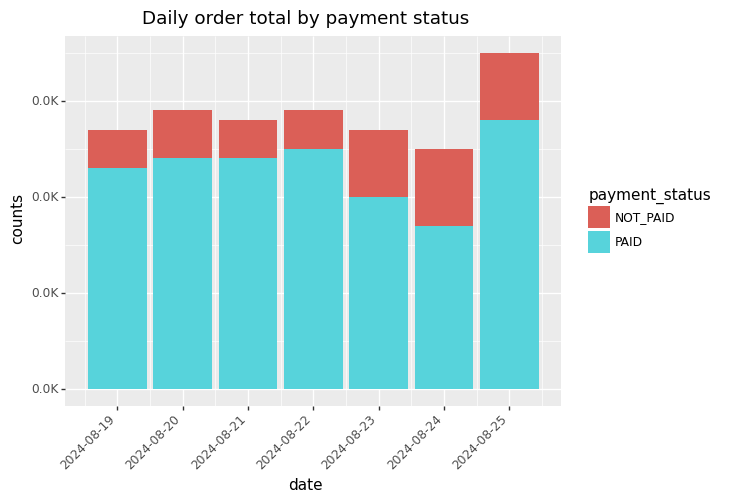

<ggplot: (394977901)>

In [17]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(orders.reset_index(), pn.aes(x='date', y='counts', fill='payment_status')) +
    pn.geom_col() +
    pn.ggtitle('Daily order total by payment status') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    #+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Production Score Distribution

In [18]:
production_score=df.groupby(
        ['production_score','payment_status'],
        as_index=False
    ).agg(
        counts=('production_score', 'count')
    ).reset_index()

production_score['production_score'] = pd.to_numeric(production_score['production_score'], errors='coerce')

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


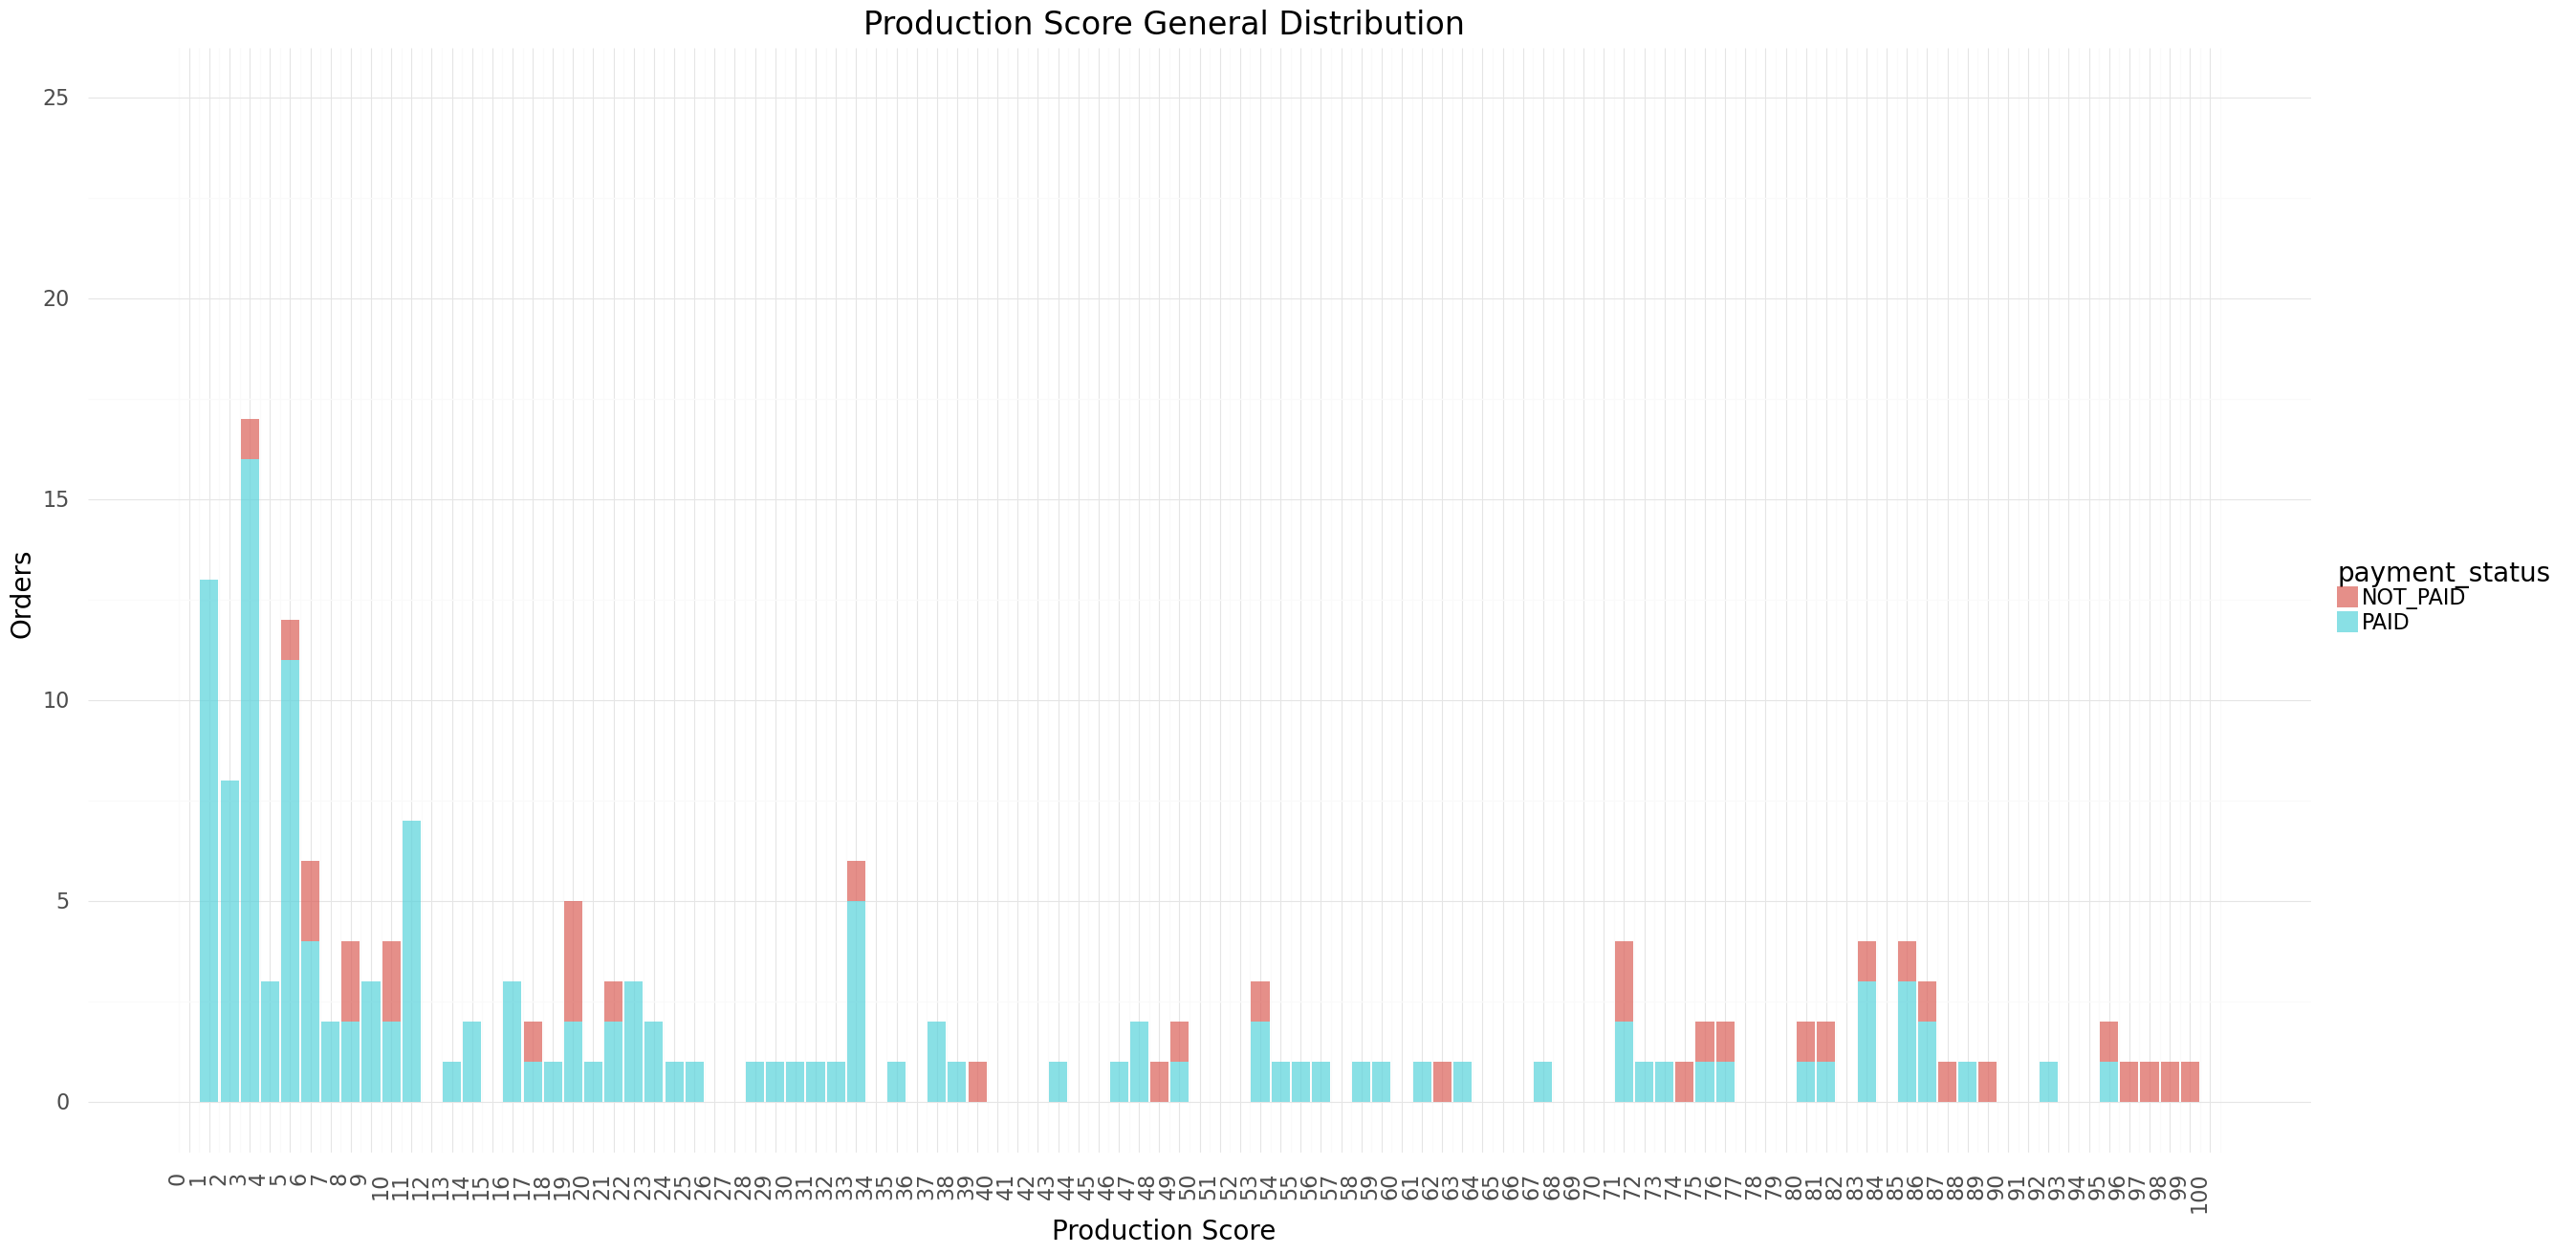

<ggplot: (397120609)>

In [19]:
(
    pn.ggplot(production_score) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_x_continuous(name="Production Score", limits=(0, 100), breaks=range(0, 101, 1)) +
    pn.theme_minimal() +
    pn.labs(title="Production Score General Distribution", y="Orders") +
    pn.theme(figure_size=(30, 15),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=24),  # Adjust title size
          axis_title=pn.element_text(size=20),  # Adjust axis titles size
          axis_text=pn.element_text(size=16),  # Adjust axis labels size
          axis_text_x=pn.element_text(angle=90, hjust=1),  # Rotate x-axis labels
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=20),  # Adjust legend title size
          legend_text=pn.element_text(size=16))  # Adjust legend text size
)

# Shadowing Score Distribution

In [20]:
shadowing_score=df.groupby(
        ['shadowing_score','payment_status'],
        as_index=False
    ).agg(
        counts=('shadowing_score', 'count')
    ).reset_index()

shadowing_score['shadowing_score'] = pd.to_numeric(shadowing_score['shadowing_score'], errors='coerce')

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.


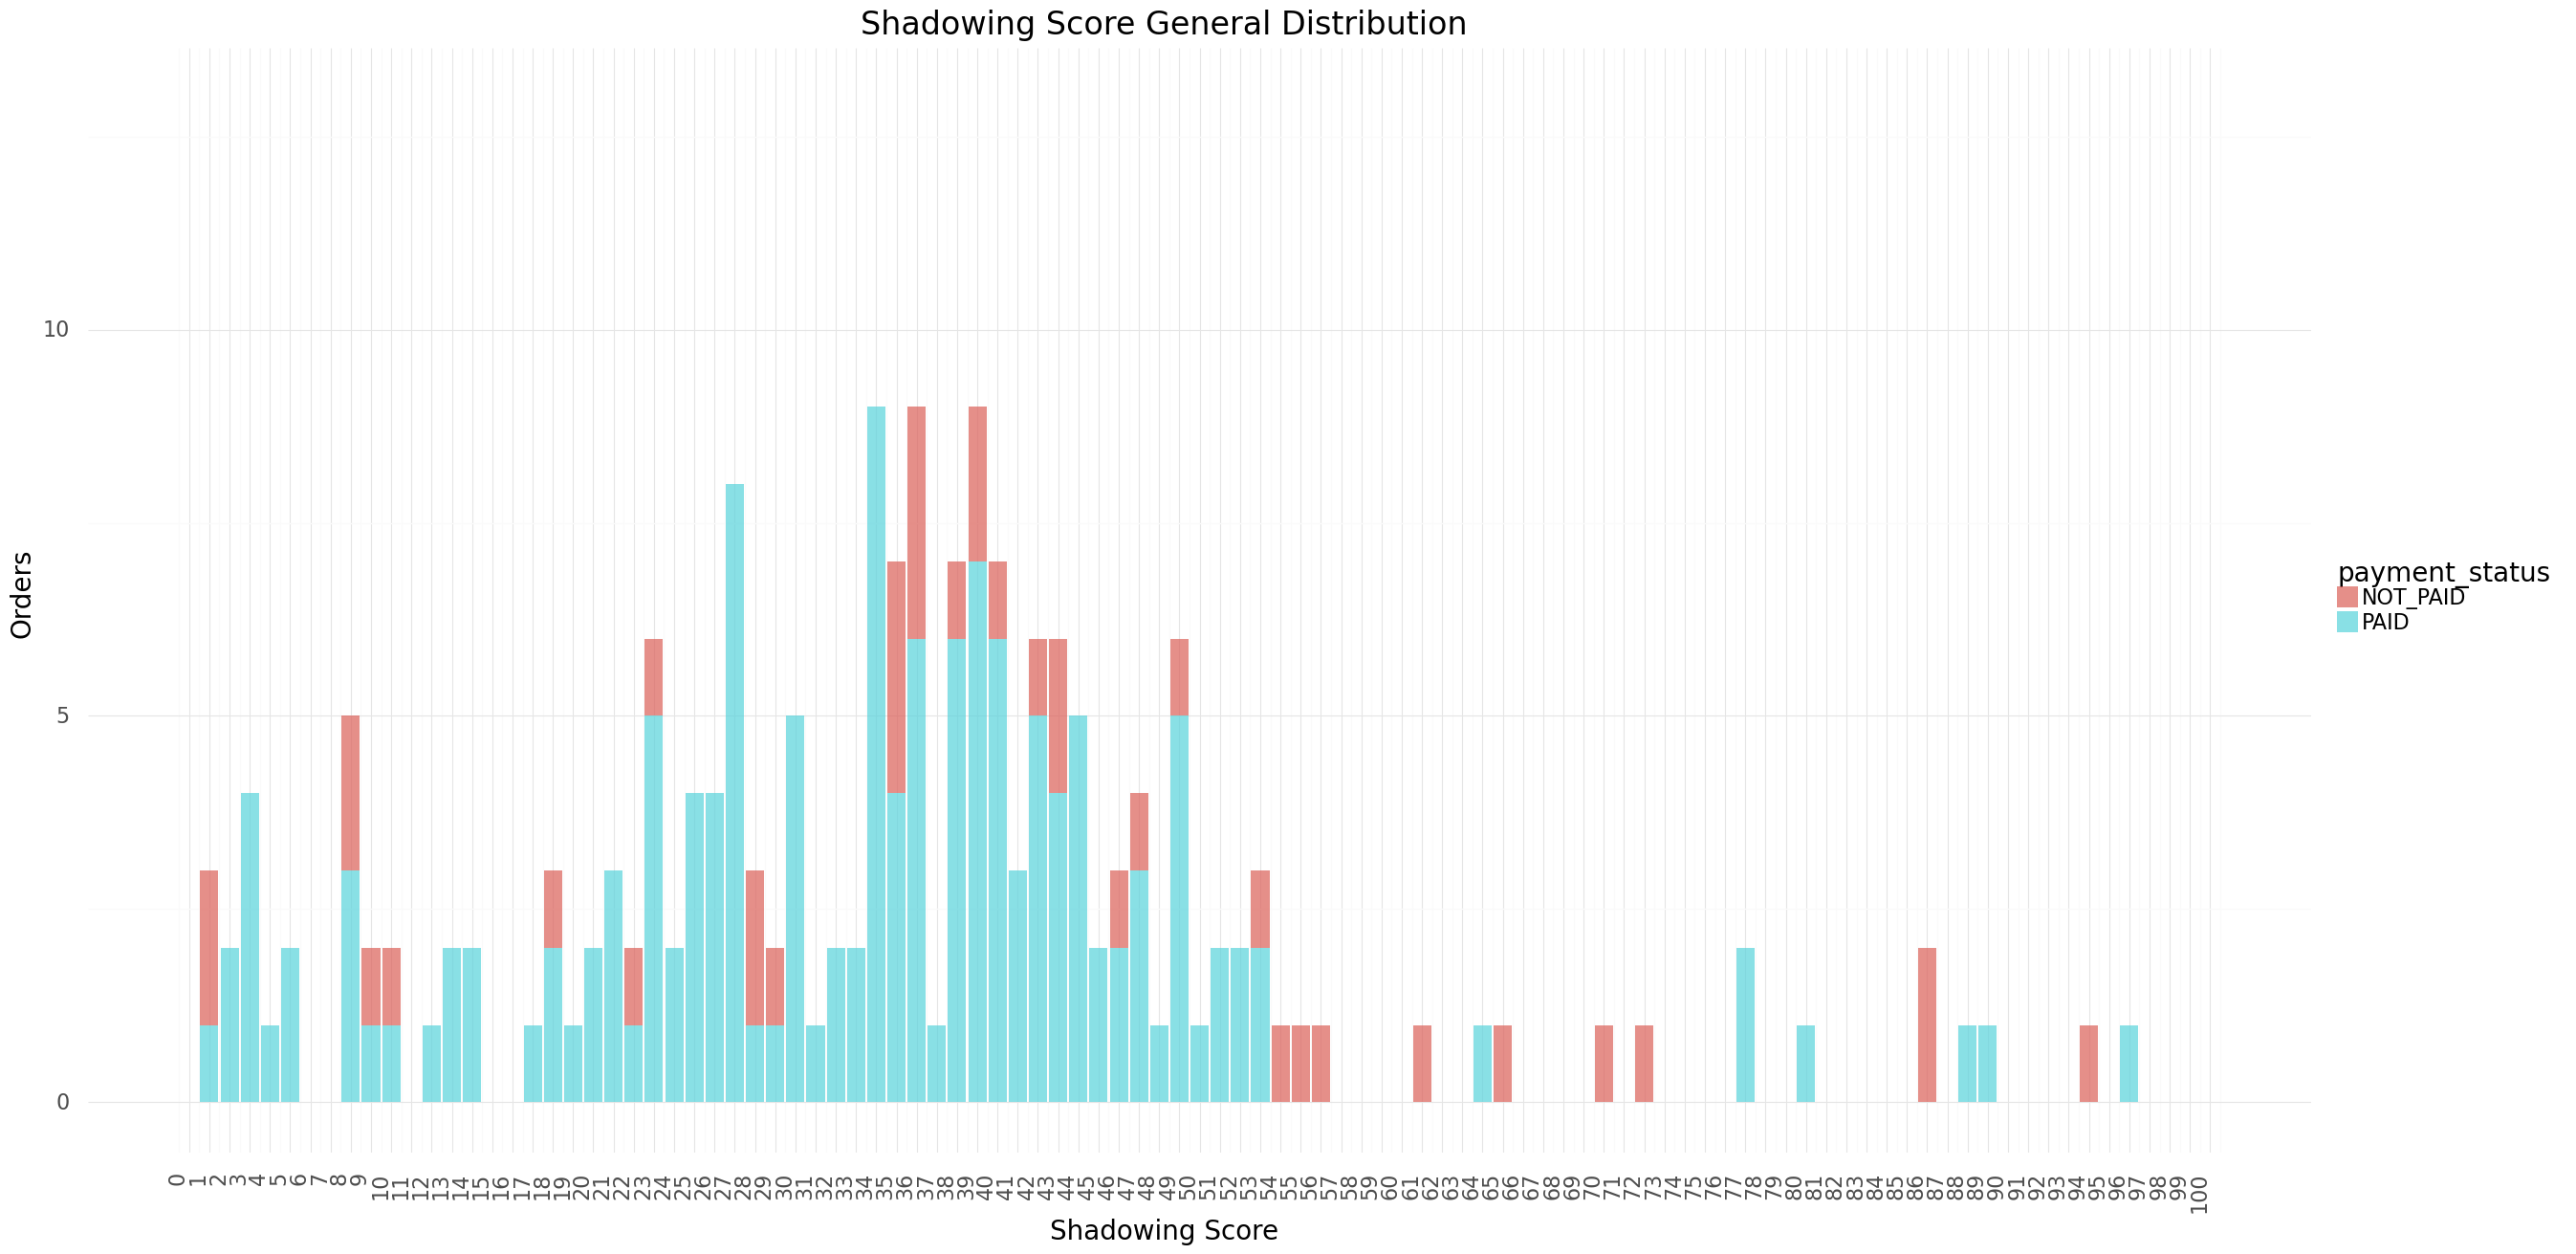

<ggplot: (397074497)>

In [21]:
(
    pn.ggplot(shadowing_score) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_x_continuous(name="Shadowing Score", limits=(0, 100), breaks=range(0, 101, 1)) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score General Distribution", y="Orders") +
    pn.theme(figure_size=(30, 15),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=24),  # Adjust title size
          axis_title=pn.element_text(size=20),  # Adjust axis titles size
          axis_text=pn.element_text(size=16),  # Adjust axis labels size
          axis_text_x=pn.element_text(angle=90, hjust=1),  # Rotate x-axis labels
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=20),  # Adjust legend title size
          legend_text=pn.element_text(size=16))  # Adjust legend text size
)

In [22]:
df

,date,customer_type,rfs_creation_date,id,customer_id,order_country,ordersCount,debtOrdersCount,order_amount_eur,debt_amount_eur,production_score,shadowing_score,checkout_status,order_creation_date,order_country_code,order_id,first_order_id,order_cancel_reason,gmv_euros,payment_status,payment_method,payment_forgiven,p_balance_eur,p_amount_paid_eur,GMV_cm_table,contribution_margin_eur
0,2024-08-21,EC,2024-08-21 11:39:42+00:00,2701195081,40172777,MA,160,1,22.86,6.69,0,32,NO_AUTH,2024-08-21 11:39:42+00:00,MA,1.008148e+11,1,None,21.840665,PAID,CASH,False,0.00,22.86,21.840665,3.587100
1,2024-08-21,EC,2024-08-21 14:10:06+00:00,2702819511,154328463,TN,113,1,8.24,5.11,1,77,NO_AUTH,2024-08-21 14:10:07+00:00,TN,1.008152e+11,1,None,2.067219,PAID,CASH,False,0.00,82.39,2.067219,0.763521
2,2024-08-24,EC,2024-08-24 16:39:23+00:00,2736358373,153897693,PL,21,1,36.98,18.50,19,40,NO_AUTH,2024-08-24 16:39:24+00:00,PL,1.008216e+11,1,USER_ERROR,15.063561,NOT_PAID,CASH,False,36.98,0.00,0.000000,1.260747
3,2024-08-23,TC,2024-08-23 13:10:05+00:00,2722756405,146715666,TN,5,1,6.75,3.03,33,43,NO_AUTH,2024-08-23 13:10:05+00:00,TN,1.008191e+11,1,None,2.843489,PAID,CASH,False,0.00,62.43,2.843489,0.128059
4,2024-08-21,NC,2024-08-21 16:37:32+00:00,2704412380,144862012,NG,1,1,4.30,3.58,37,24,NO_AUTH,2024-08-21 16:37:32+00:00,NG,1.008155e+11,1,None,3.889600,PAID,CASH,False,0.00,4.30,3.889600,0.457300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2024-08-22,TC,2024-08-22 23:06:29+00:00,2718766945,54780414,MA,3,1,11.04,23.70,47,96,NO_AUTH,2024-08-22 23:06:29+00:00,MA,1.008183e+11,1,None,10.765032,PAID,CASH,False,0.00,11.04,10.765032,1.674300
196,2024-08-20,EC,2024-08-20 08:59:58+00:00,2689688042,19478024,MA,260,1,27.22,10.03,0,27,NO_AUTH,2024-08-20 08:59:58+00:00,MA,1.008126e+11,1,None,16.071304,PAID,CASH,False,0.00,27.52,16.071304,0.819264
197,2024-08-22,EC,2024-08-22 20:02:58+00:00,2717429750,29905093,HR,45,1,44.81,26.61,5,43,NO_AUTH,2024-08-22 20:02:58+00:00,HR,1.008181e+11,1,None,18.000000,PAID,CASH,False,0.00,44.81,18.000000,1.922000
198,2024-08-21,EC,2024-08-21 11:38:10+00:00,2701176648,40172777,MA,159,1,12.27,6.71,0,31,NO_AUTH,2024-08-21 11:38:11+00:00,MA,1.008148e+11,1,None,11.245619,PAID,CASH,False,0.00,12.27,11.245619,2.004100


In [23]:
# Production Score

df_production_score=pd.DataFrame(df['production_score'].value_counts()/len(df))
df_production_score = df_production_score.reset_index()
df_production_score.columns=['production_score','percentage']
#df_production_score

In [24]:
# Shadowing Score

df_shadowing_score=pd.DataFrame(df['shadowing_score'].value_counts()/len(df))
df_shadowing_score = df_shadowing_score.reset_index()
df_shadowing_score.columns=['shadowing_score','percentage']
#df_shadowing_score

In [25]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(df_production_score,df_shadowing_score, titles=['Production Score','Shadowing Score'])

,production_score,percentage
0,0,0.125
1,3,0.085
2,1,0.065
3,5,0.060
4,2,0.040
5,11,0.035
6,33,0.030
7,6,0.030
8,19,0.025
9,10,0.020


# Crosstab

In [26]:
# Ground truth, the user has a successful verification and at least 1 order is a trusted user, in case not a bot.
pd.crosstab(
    df['customer_type'],
    df['payment_status'],
    dropna=False,
    normalize='all'
)

payment_status,NOT_PAID,PAID
customer_type,,
EC,0.125,0.685
NC,0.030,0.030
TC,0.040,0.090


# Adding unpaid flag

In [27]:
df['unpaid']=df['payment_status'].apply(lambda x: 0 if x == 'NOT_PAID' else 1)
df['production_score'] = df['production_score'].astype(int)
df['shadowing_score'] = df['shadowing_score'].astype(int)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1099018825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1099018825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1099018825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

# Production score evaluation

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1154602147.py:4: RuntimeWarning: invalid value encountered in divide


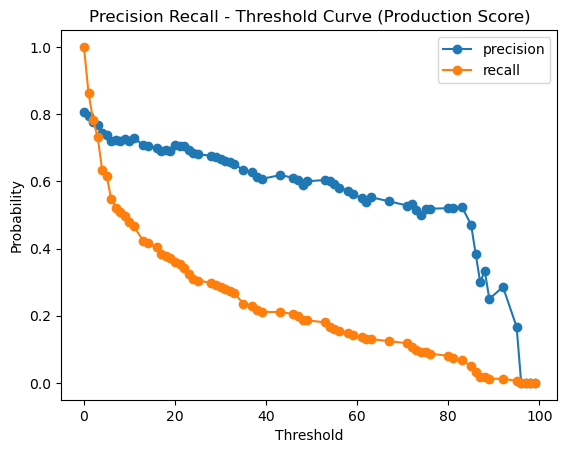

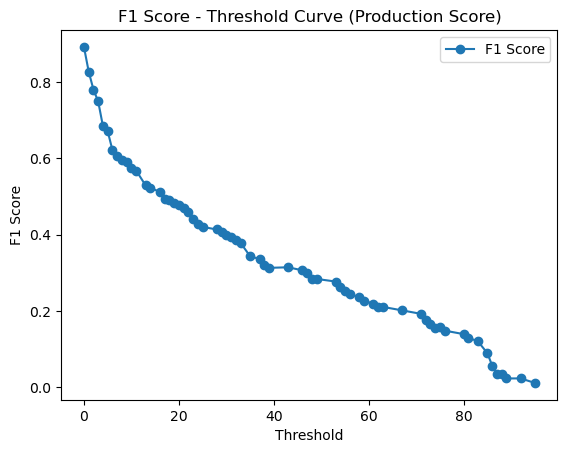

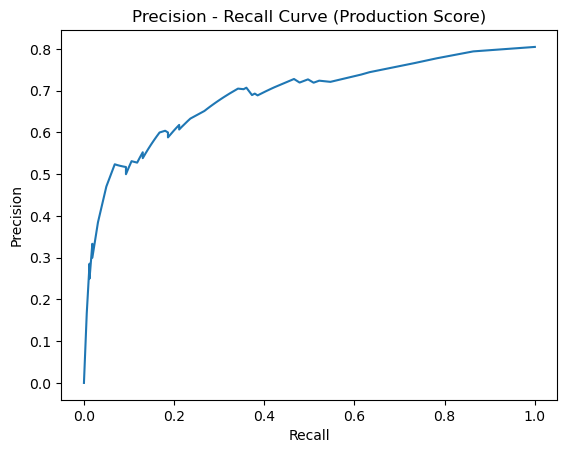

In [28]:

# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is production model for detecting unpaid cash being 1 the positive label.
prec_1, recall_1, thresholds_1 = precision_recall_curve(df['unpaid'].values, df['production_score'].values, pos_label=1)
f1_scores_1 = 2 * (prec_1* recall_1) / (prec_1 + recall_1)

plt.plot(thresholds_1[:], prec_1[:-1]
         , label='precision', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Production Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_1[:], f1_scores_1[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_1[:-1], prec_1[:-1])
plt.title("Precision - Recall Curve (Production Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()



In [29]:
#f1_scores = 2 * (precision * recall) / (precision + recall)

#  Shadowing score evaluation

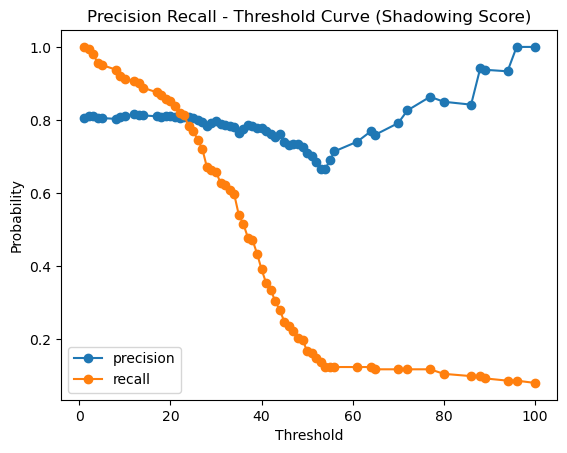

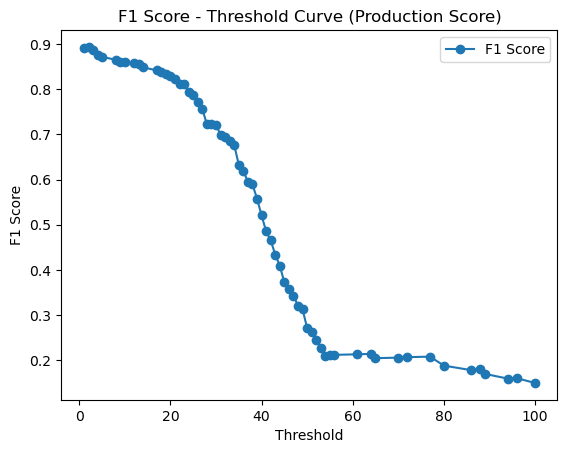

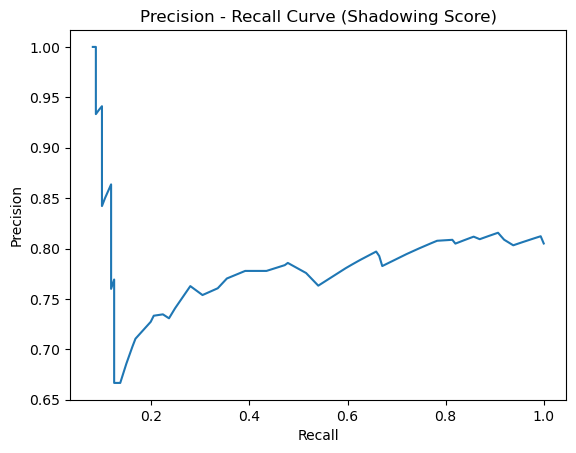

In [30]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is shadowing model for detecting unpaid cash being 1 the positive label.
prec_2, recall_2, thresholds_2 = precision_recall_curve(df['unpaid'].values, df['shadowing_score'].values, pos_label=1)
f1_scores_2 = 2 * (prec_2* recall_2) / (prec_2 + recall_2)

plt.plot(thresholds_2[:], prec_2[:-1], label='precision', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Shadowing Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_2[:], f1_scores_2[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")


plt.figure()

plt.plot(recall_2[:-1], prec_2[:-1])
plt.title("Precision - Recall Curve (Shadowing Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

# Model comparison

In [31]:
# Convert payment_status to binary where NOT_PAID is 1 and PAID is 0
df['true_label'] = df['unpaid']

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1050085443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/47345187.py:5: RuntimeWarning: invalid value encountered in divide


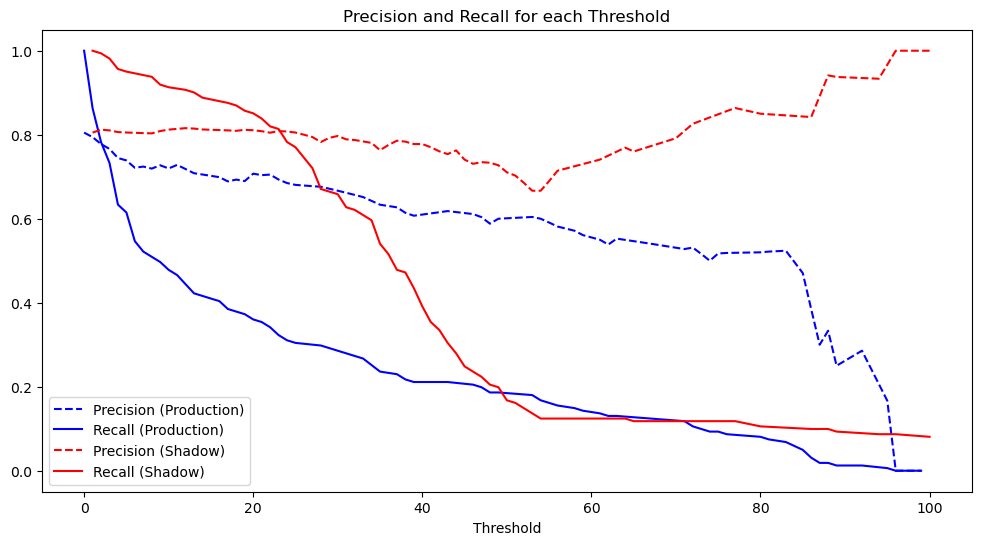

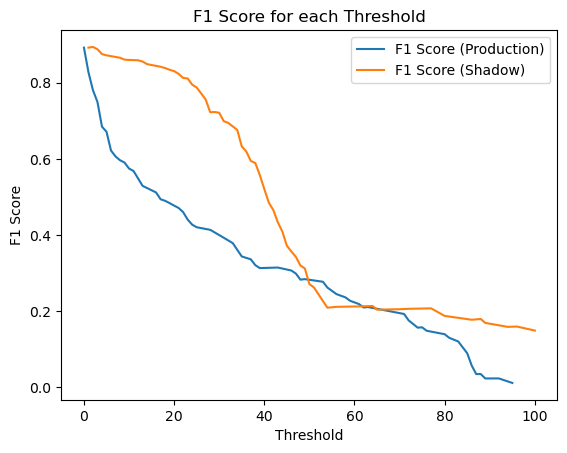

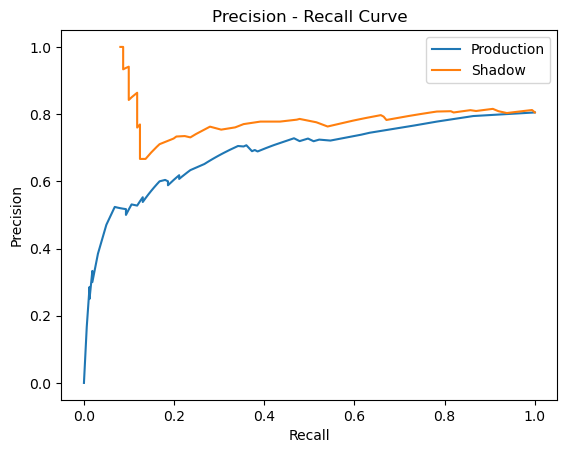

In [32]:
# Calculate precision, recall, and thresholds for each model
precision_production, recall_production, thresholds_production = precision_recall_curve(df['true_label'], df['production_score'])
precision_shadow, recall_shadow, thresholds_shadow = precision_recall_curve(df['true_label'], df['shadowing_score'])

f1_production = 2 * (precision_production* recall_production) / (precision_production + recall_production)
f1_shadow = 2 * (precision_shadow* recall_shadow) / (precision_shadow + recall_shadow)

# Plot precision and recall against the threshold for each model
plt.figure(figsize=(12, 6))

plt.plot(thresholds_production, precision_production[:-1], 'b--', label='Precision (Production)')
plt.plot(thresholds_production, recall_production[:-1], 'b-', label='Recall (Production)')
plt.plot(thresholds_shadow, precision_shadow[:-1], 'r--', label='Precision (Shadow)')
plt.plot(thresholds_shadow, recall_shadow[:-1], 'r-', label='Recall (Shadow)')
plt.xlabel('Threshold')
plt.title('Precision and Recall for each Threshold')
plt.legend()

plt.figure()

plt.plot(thresholds_production, f1_production[:-1], label='F1 Score (Production)')
plt.plot(thresholds_shadow, f1_shadow[:-1], label='F1 Score (Shadow)')
plt.legend()
plt.title("F1 Score for each Threshold")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_production[:-1], precision_production[:-1], label="Production")
plt.plot(recall_shadow[:-1], precision_shadow[:-1], label="Shadow")
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()  # This line will display the labels
plt.show()


plt.show()

# ROC Curves with AUC

Thresholds: [inf 99. 96. 95. 92. 89. 88. 87. 86. 83. 75. 74. 72. 71. 63. 62. 54. 53.
 49. 48. 47. 43. 39. 38. 37. 35. 33. 24. 23. 22. 21. 20. 19. 18. 17. 16.
 14. 13. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]
AUC: 0.27799012581621274


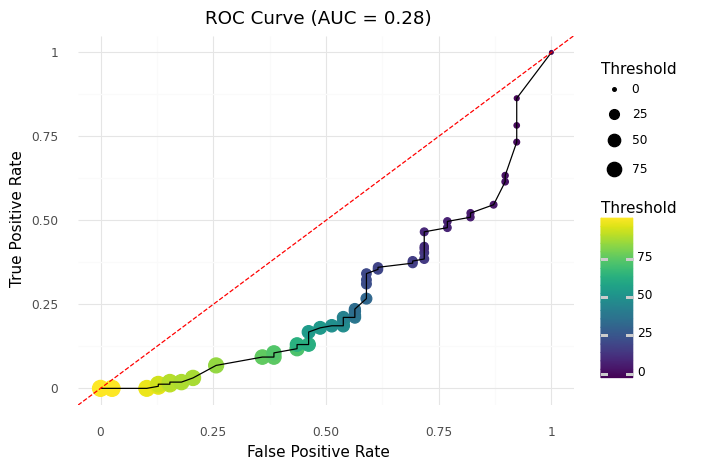

<ggplot: (402399753)>

In [33]:
# Production model
plot_roc_curve(df, preds_col='production_score', label_col='unpaid')

Thresholds: [ inf 100.  96.  94.  88.  86.  80.  77.  65.  64.  54.  53.  51.  50.
  49.  48.  47.  46.  45.  44.  43.  42.  41.  40.  39.  38.  37.  36.
  35.  34.  32.  31.  30.  29.  28.  27.  25.  24.  23.  22.  21.  20.
  19.  18.  17.  13.  12.   9.   8.   5.   4.   3.   2.   1.]
AUC: 0.4532568880394967


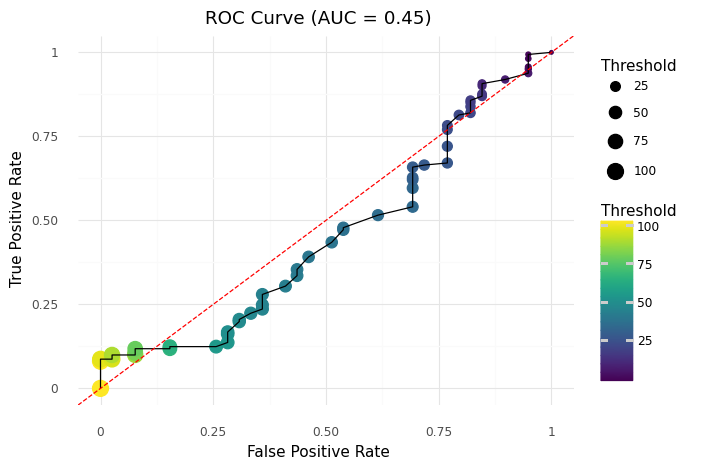

<ggplot: (402467197)>

In [34]:
# Shadowing Model
plot_roc_curve(df, preds_col='shadowing_score', label_col='unpaid')

# CASH ARREARS WITH 95% OF DATA

Because we have a smalll data set we will run to confirm assumptions with the 95% of the data, for sure we know that will be biassed from start but, we want to have a clear outcome of the expecation we must have with the retrained model

##### It is important to know that thedataset is biassed due that half ot it is not allowed to order by the current rules

In [61]:
#new query
query= f'''
SELECT DATE(DATE_TRUNC('day', rfs.p_creation_date)) AS date
        , CASE 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 1 THEN 'NC' 
                WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) > 1 AND CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) < 5 THEN 'TC' 
        ELSE 'EC' END AS customer_type
        , rfs.risk_feature_snapshot_creation_datetime AS rfs_creation_date
        , rfs.risk_feature_snapshot_id AS id
        , rfs.customer_id
        , json_extract_scalar(rfs.features, '$.order.countryCode') AS order_country
        , json_extract_scalar(rfs.features, '$.customer.ordersCount') AS ordersCount
        , json_extract_scalar(rfs.features, '$.customer.debtOrdersCount') AS debtOrdersCount 
        
        , JSON_EXTRACT_SCALAR(rfs.features, '$.order.amountInEur.amountMajor')   AS order_amount_eur
        , JSON_EXTRACT_SCALAR(rfs.features, '$.customer.debtTotalInEur')         AS debt_amount_eur
        
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_ca.score'), ' ') AS production_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_ca.shadowing.ml_ca_v0.score'),' ') AS shadowing_score
        

        -- CHECKOUT 
        , co.checkout_status
        
        -- ORDERS 
        , o.order_created_at AS order_creation_date 
        , o.order_country_code
        , o.order_id
        , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
        , o.order_cancel_reason
        , o.order_total_purchase_eur AS gmv_euros
        
        -- PAYMENTS
        , p.payment_status
        , p.payment_method
        , p.payment_forgiven
        , round(round(abs(p.balance) / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_balance_eur
        , round(round(p.amount_paid / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_amount_paid_eur
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced WHERE TRUE 
            AND checkpoint = 'checkout' 
            AND crc32(cast ('arrears-cg' || cast(customer_id as varchar) as varbinary)) > (0.05 * 4294967295) 
            AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') 
            AND CAST(json_extract_scalar(features, '$.customer.debtOrdersCount') AS INT)>0 
            AND json_extract_scalar(features, '$.payment_method.type')='CASH'
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_ca.shadowing.ml_ca_v0.score'),' ') IS NOT NULL
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_ca.score'), ' ') IS NOT NULL
    ) rfs
    LEFT JOIN sensitive_delta.sensitive_fintech__checkout_orders__odp.checkout_orders co ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2                 o ON o.order_id = co.order_id AND DATE(o.p_creation_date)>=DATE('{start_date}') AND DATE(o.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.fintech_payments_odp.payments                                      p ON p.order_id = o.order_id AND DATE(p.p_creation_date)>=DATE('{start_date}') AND DATE(p.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level                     cm ON cm.order_id=o.order_id AND DATE(cm.p_creation_date)>=DATE('{start_date}') AND DATE(cm.p_creation_date)<DATE('{end_date}')  


'''


In [36]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_62479/1346933151.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


# EDA

In [37]:
df.dtypes

date                                    object
customer_type                           object
rfs_creation_date          datetime64[ns, UTC]
id                                       int64
customer_id                              int64
order_country                           object
ordersCount                             object
debtOrdersCount                         object
order_amount_eur                        object
debt_amount_eur                         object
production_score                        object
shadowing_score                         object
checkout_status                         object
order_creation_date        datetime64[ns, UTC]
order_country_code                      object
order_id                               float64
first_order_id                           int64
order_cancel_reason                     object
gmv_euros                              float64
payment_status                          object
payment_method                          object
payment_forgi

In [38]:
len(df)

6315

In [39]:
df.isna().sum()

date                          0
customer_type                 0
rfs_creation_date             0
id                            0
customer_id                   0
order_country                 0
ordersCount                   0
debtOrdersCount               0
order_amount_eur              0
debt_amount_eur               0
production_score              0
shadowing_score             427
checkout_status               0
order_creation_date        4082
order_country_code         4082
order_id                   4082
first_order_id                0
order_cancel_reason        6056
gmv_euros                  4082
payment_status             4082
payment_method             4082
payment_forgiven           4082
p_balance_eur              4082
p_amount_paid_eur          4082
GMV_cm_table               4082
contribution_margin_eur    4082
dtype: int64

In [40]:
df['order_id'].isna().sum()/len(df)

0.6463974663499604

### NOTE
20% of the CG does not have an order, probably this because was affected or blocked by RE rules that do not consider the exclusion of the CG 

In [41]:
df['date']=pd.to_datetime(df['date'])
df['debtOrdersCount']=df['debtOrdersCount'].astype('int64')
df['order_amount_eur']=df['order_amount_eur'].astype('float64')
df['debt_amount_eur']=df['debt_amount_eur'].astype('float64')
df['shadowing_score'] = df['shadowing_score'].fillna('100')
df2=df.copy()
df = df.dropna(subset=['order_id'])

In [42]:
orders = df[['date', 'payment_status']].groupby(
    ['payment_status', pd.Grouper(key='date', freq='1D')]
    ).agg(
        counts = ('date', 'count')
    ).reset_index()

In [43]:
orders['payment_status'] = orders['payment_status'].astype('category')

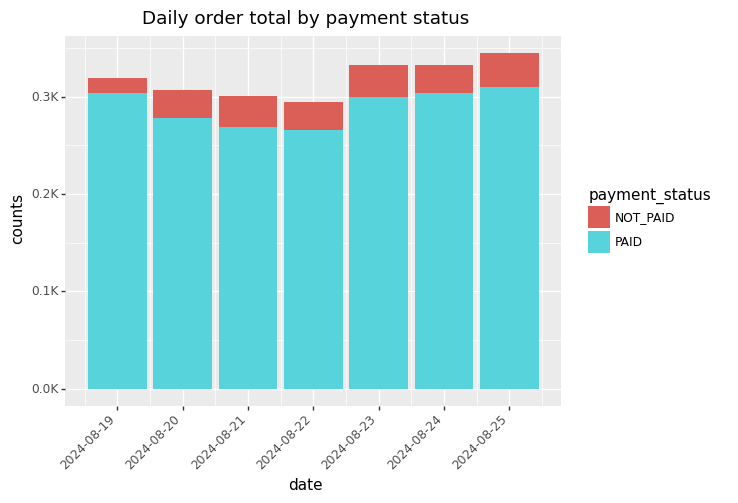

<ggplot: (335572057)>

In [44]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(orders.reset_index(), pn.aes(x='date', y='counts', fill='payment_status')) +
    pn.geom_col() +
    pn.ggtitle('Daily order total by payment status') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    #+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Production Score Distribution

In [45]:
production_score=df.groupby(
        ['production_score','payment_status'],
        as_index=False
    ).agg(
        counts=('production_score', 'count')
    ).reset_index()

production_score['production_score'] = pd.to_numeric(production_score['production_score'], errors='coerce')

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


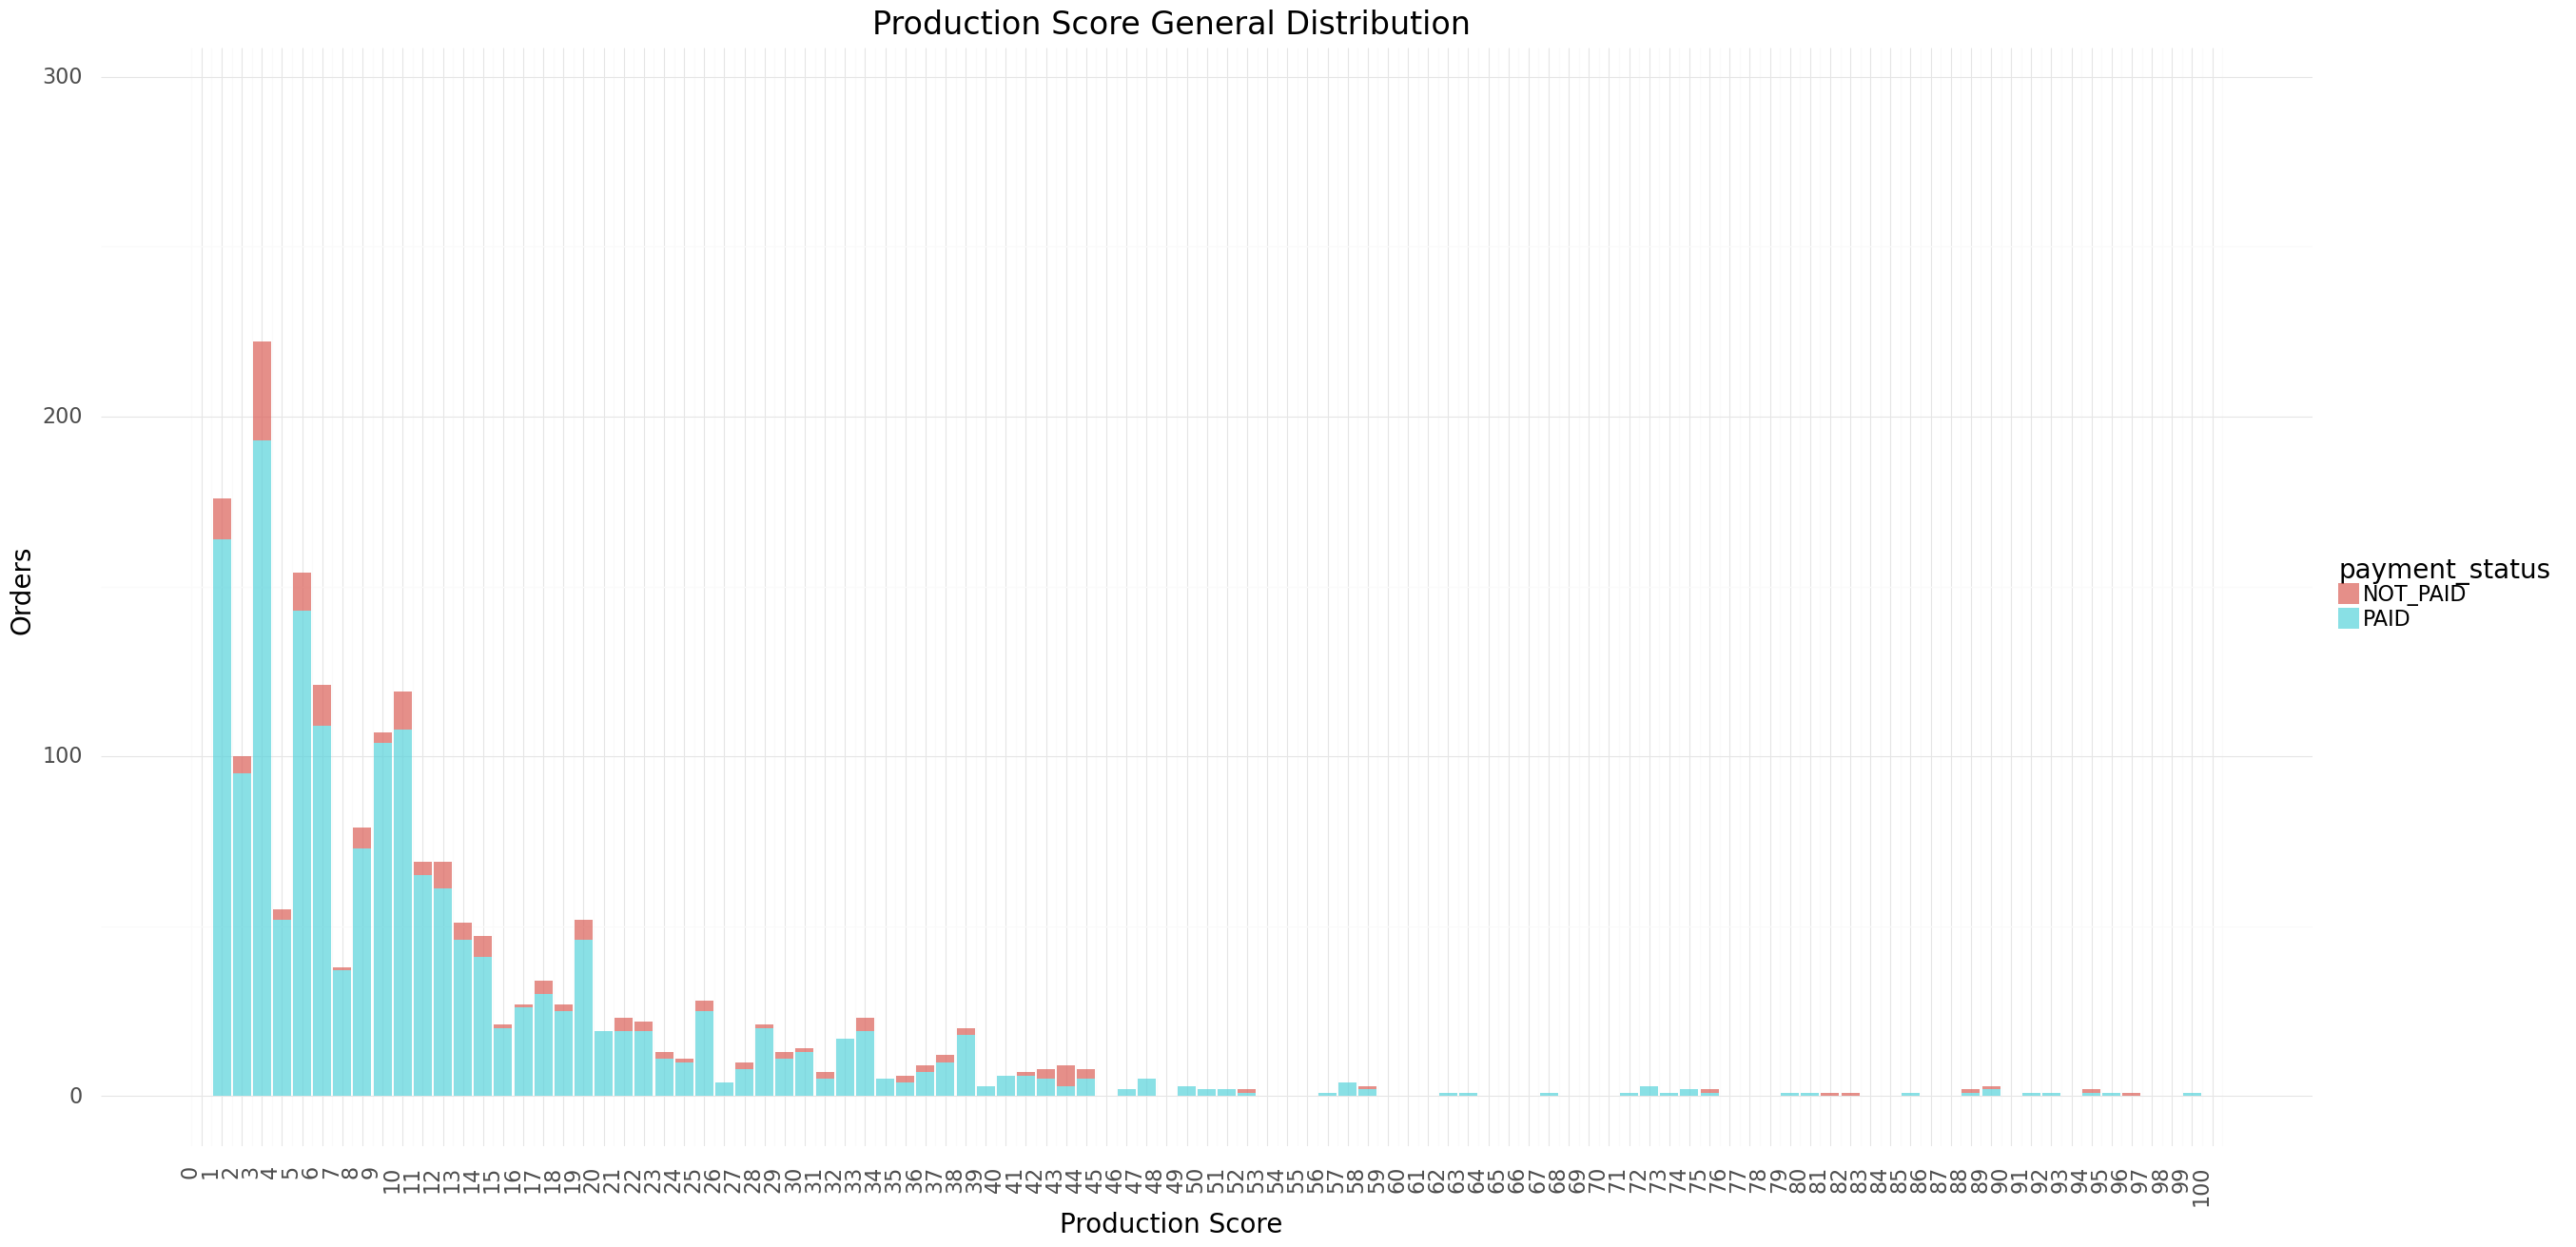

<ggplot: (335660065)>

In [46]:
(
    pn.ggplot(production_score) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_x_continuous(name="Production Score", limits=(0, 100), breaks=range(0, 101, 1)) +
    pn.theme_minimal() +
    pn.labs(title="Production Score General Distribution", y="Orders") +
    pn.theme(figure_size=(30, 15),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=24),  # Adjust title size
          axis_title=pn.element_text(size=20),  # Adjust axis titles size
          axis_text=pn.element_text(size=16),  # Adjust axis labels size
          axis_text_x=pn.element_text(angle=90, hjust=1),  # Rotate x-axis labels
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=20),  # Adjust legend title size
          legend_text=pn.element_text(size=16))  # Adjust legend text size
)

# Shadowing Score Distribution

In [47]:
shadowing_score=df.groupby(
        ['shadowing_score','payment_status'],
        as_index=False
    ).agg(
        counts=('shadowing_score', 'count')
    ).reset_index()

shadowing_score['shadowing_score'] = pd.to_numeric(shadowing_score['shadowing_score'], errors='coerce')

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 3 rows containing missing values.


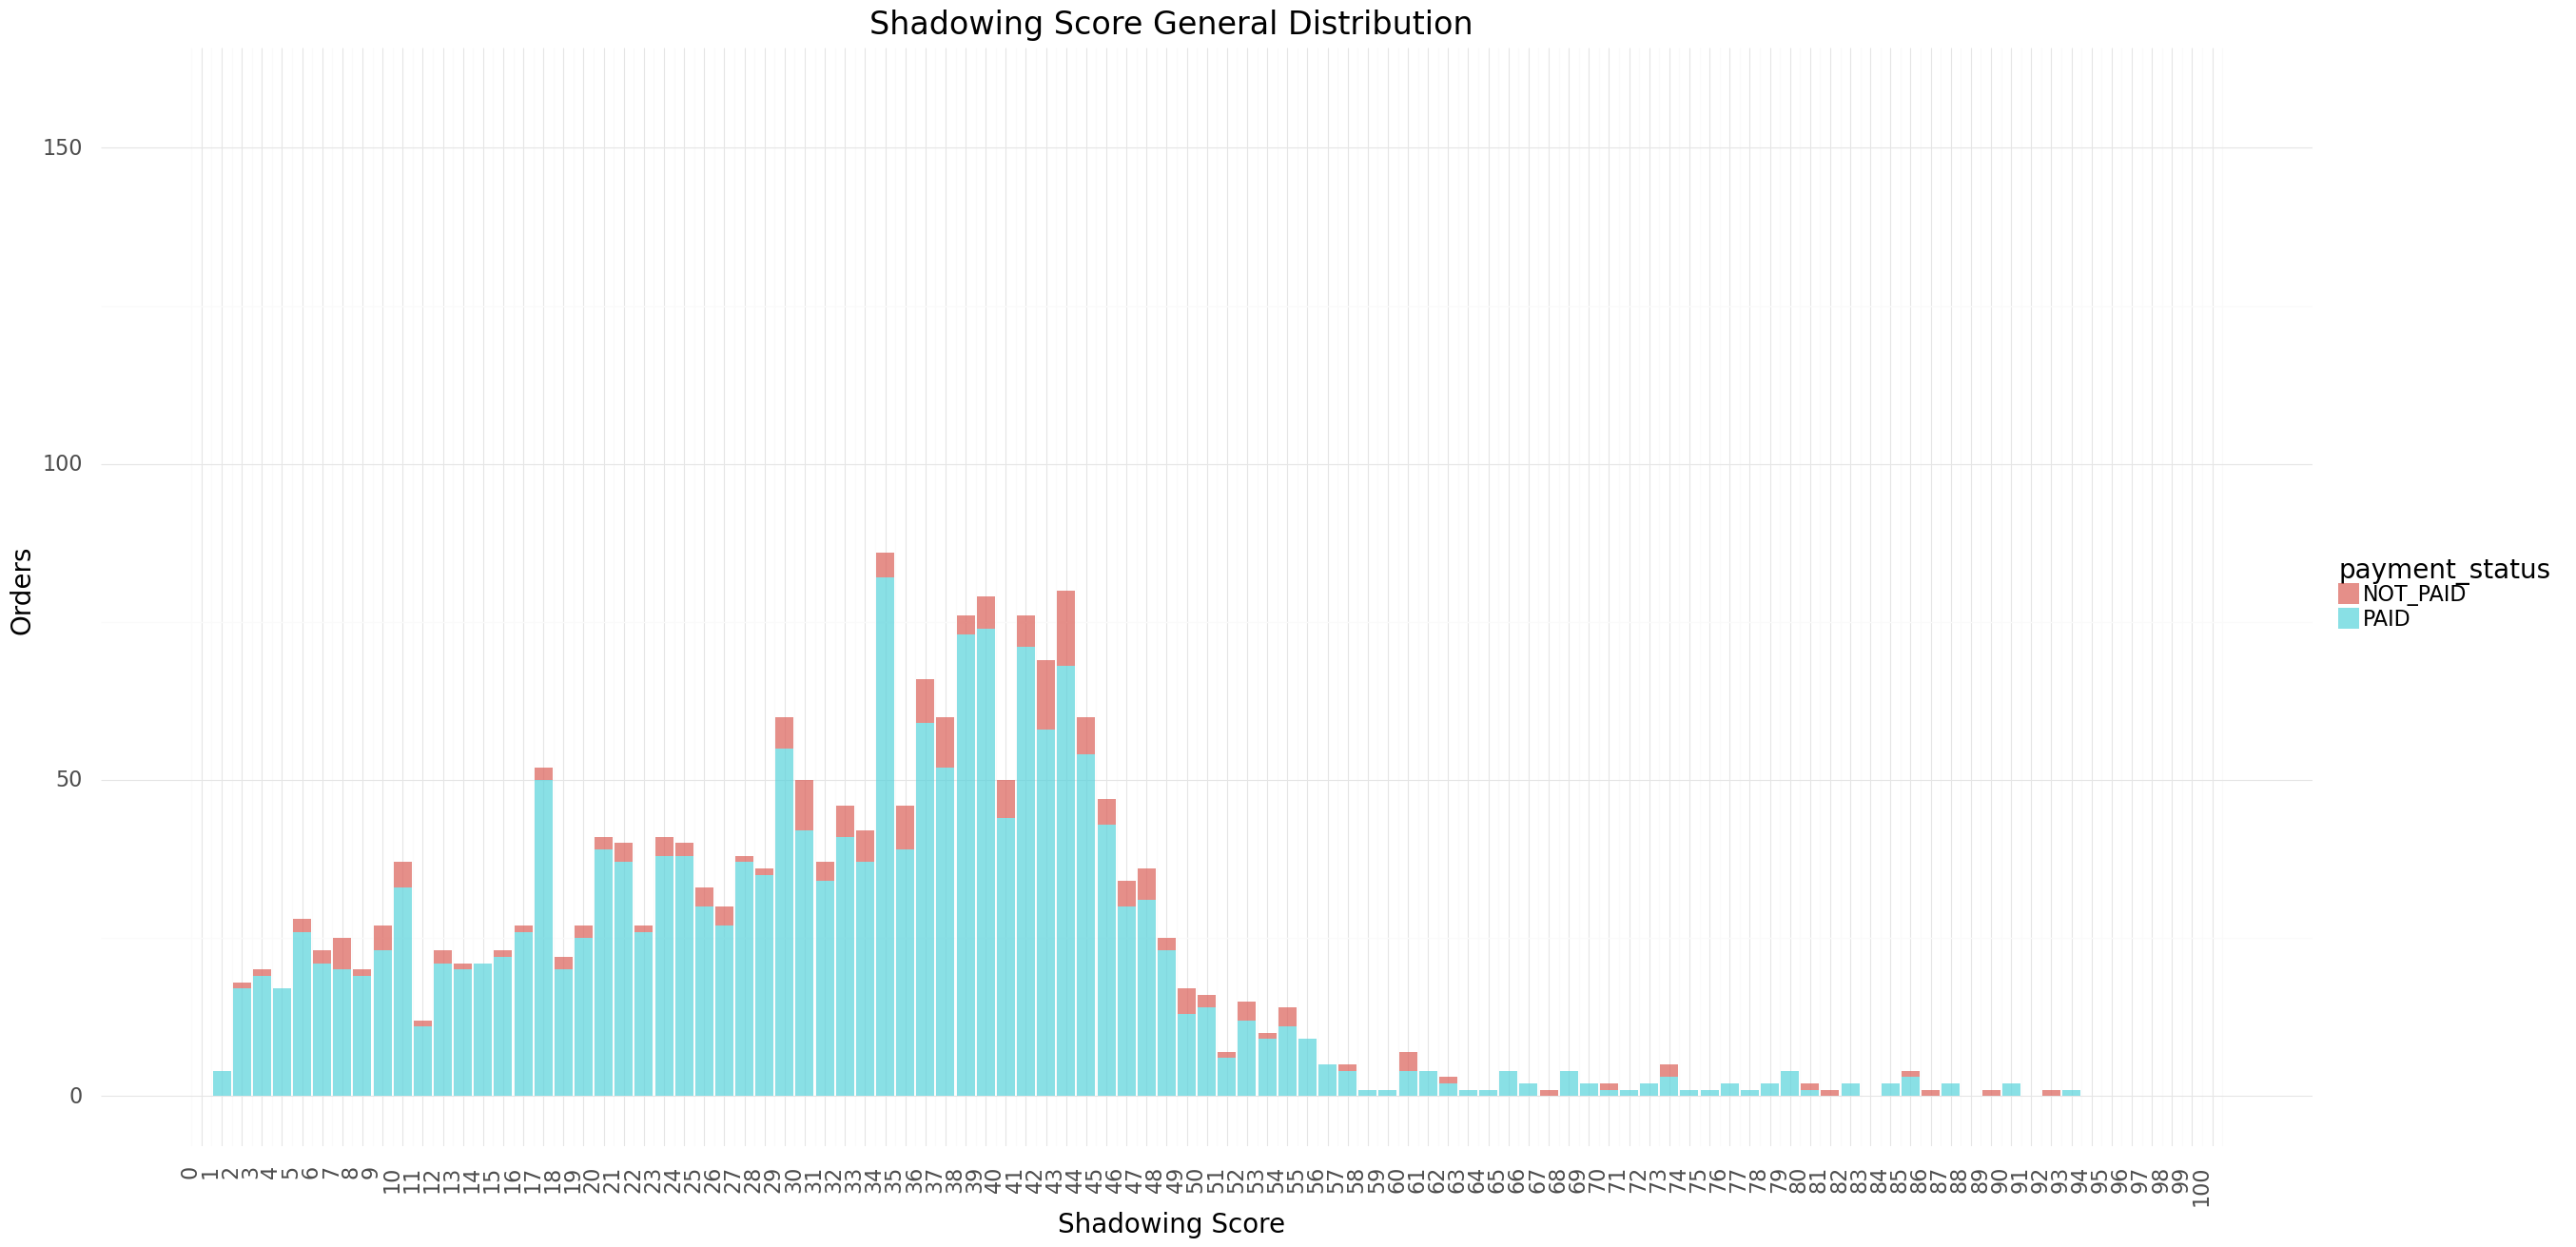

<ggplot: (335588577)>

In [48]:
(
    pn.ggplot(shadowing_score) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_x_continuous(name="Shadowing Score", limits=(0, 100), breaks=range(0, 101, 1)) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score General Distribution", y="Orders") +
    pn.theme(figure_size=(30, 15),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=24),  # Adjust title size
          axis_title=pn.element_text(size=20),  # Adjust axis titles size
          axis_text=pn.element_text(size=16),  # Adjust axis labels size
          axis_text_x=pn.element_text(angle=90, hjust=1),  # Rotate x-axis labels
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=20),  # Adjust legend title size
          legend_text=pn.element_text(size=16))  # Adjust legend text size
)

In [49]:
df

,date,customer_type,rfs_creation_date,id,customer_id,order_country,ordersCount,debtOrdersCount,order_amount_eur,debt_amount_eur,production_score,shadowing_score,checkout_status,order_creation_date,order_country_code,order_id,first_order_id,order_cancel_reason,gmv_euros,payment_status,payment_method,payment_forgiven,p_balance_eur,p_amount_paid_eur,GMV_cm_table,contribution_margin_eur
0,2024-08-24,EC,2024-08-24 13:07:57+00:00,2733842893,151352869,TN,56,1,10.87,4.10,7,32,NO_AUTH,2024-08-24 13:07:58+00:00,TN,1.008211e+11,1,None,6.433256,PAID,CASH,False,0.0,108.69,6.433256,0.883167
1,2024-08-22,EC,2024-08-22 09:29:26+00:00,2710279477,53243341,RO,48,1,19.57,15.89,1,39,NO_AUTH,2024-08-22 09:29:26+00:00,RO,1.008166e+11,1,None,19.891674,PAID,CASH,False,0.0,19.57,19.891674,2.227900
2,2024-08-22,TC,2024-08-22 23:36:08+00:00,2718861952,144893599,IT,5,1,37.58,19.29,22,43,NO_AUTH,2024-08-22 23:36:08+00:00,IT,1.008183e+11,1,None,16.000000,PAID,CASH,False,0.0,37.58,16.000000,3.841049
3,2024-08-20,EC,2024-08-20 09:59:47+00:00,2690101999,174050812,MA,5,1,21.23,7.34,35,37,NO_AUTH,2024-08-20 09:59:48+00:00,MA,1.008126e+11,1,None,12.570255,PAID,CASH,False,0.0,21.23,12.570255,2.025751
4,2024-08-25,EC,2024-08-25 20:13:30+00:00,2753093013,21505066,IT,11,1,17.10,3.60,19,39,NO_AUTH,2024-08-25 20:13:30+00:00,IT,1.008245e+11,1,None,13.300000,PAID,CASH,False,0.0,17.10,13.300000,3.406826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,2024-08-21,EC,2024-08-21 18:25:03+00:00,2705937708,91752192,BG,57,1,25.79,13.55,1,38,NO_AUTH,2024-08-21 18:25:03+00:00,BG,1.008158e+11,1,None,12.147490,PAID,CASH,False,0.0,25.79,12.147490,1.400107
2229,2024-08-21,EC,2024-08-21 18:50:41+00:00,2706347167,128274049,TN,138,1,7.86,2.74,3,28,NO_AUTH,2024-08-21 18:50:41+00:00,TN,1.008159e+11,1,None,5.758681,PAID,CASH,False,0.0,78.55,5.758681,0.302590
2230,2024-08-21,EC,2024-08-21 19:41:23+00:00,2707137522,93678209,IT,83,1,37.65,15.30,0,34,NO_AUTH,2024-08-21 19:41:23+00:00,IT,1.008160e+11,1,None,19.560000,PAID,CASH,False,0.0,37.65,19.560000,3.540085
2231,2024-08-25,EC,2024-08-25 16:57:18+00:00,2749097885,50534908,KE,399,1,17.92,13.08,5,33,NO_AUTH,2024-08-25 16:57:18+00:00,KE,1.008238e+11,1,None,4.335676,PAID,CASH,False,0.0,17.92,4.335676,0.733990


In [50]:
# Production Score

df_production_score=pd.DataFrame(df['production_score'].value_counts()/len(df))
df_production_score = df_production_score.reset_index()
df_production_score.columns=['production_score','percentage']
#df_production_score

In [51]:
# Shadowing Score

df_shadowing_score=pd.DataFrame(df['shadowing_score'].value_counts()/len(df))
df_shadowing_score = df_shadowing_score.reset_index()
df_shadowing_score.columns=['shadowing_score','percentage']
#df_shadowing_score

In [52]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(df_production_score,df_shadowing_score, titles=['Production Score','Shadowing Score'])

,production_score,percentage
0,0,0.131661
1,3,0.099418
2,1,0.078818
3,5,0.068966
4,6,0.054187
5,10,0.053292
6,9,0.047918
7,2,0.044783
8,8,0.035378
9,12,0.030900


# Crosstab

In [53]:
# Ground truth, the user has a successful verification and at least 1 order is a trusted user, in case not a bot.
pd.crosstab(
    df['customer_type'],
    df['payment_status'],
    dropna=False,
    normalize='all'
)

payment_status,NOT_PAID,PAID
customer_type,,
EC,0.085535,0.879086
NC,0.000896,0.007613
TC,0.004030,0.022839


# Adding unpaid flag

In [54]:
df['unpaid']=df['payment_status'].apply(lambda x: 0 if x == 'NOT_PAID' else 1)
df['production_score'] = df['production_score'].astype(int)
df['shadowing_score'] = df['shadowing_score'].astype(int)

# Production score evaluation

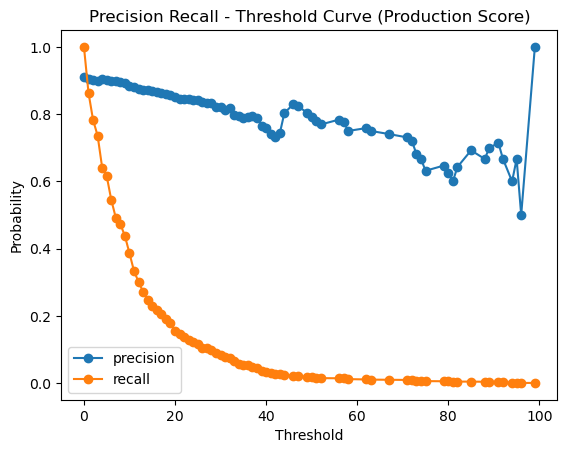

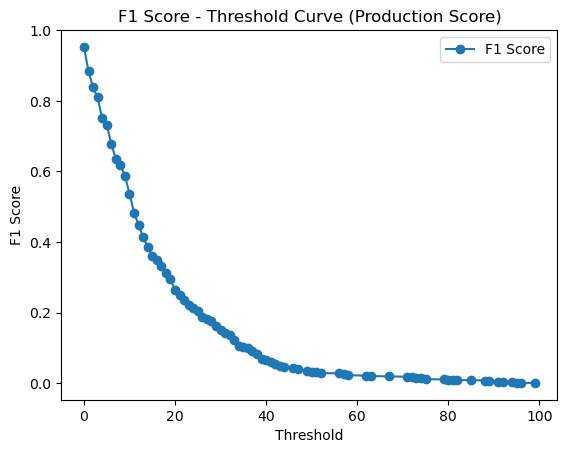

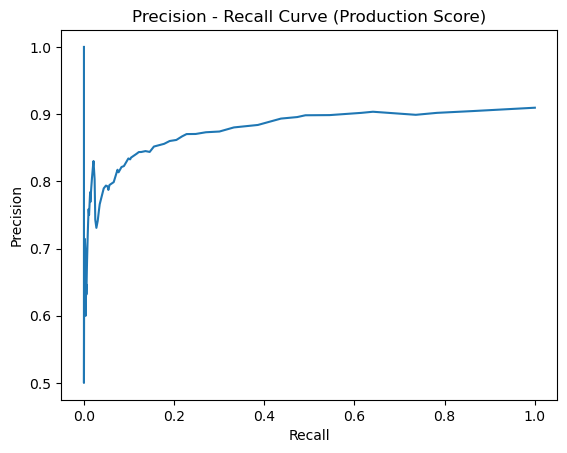

In [55]:

# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is production model for detecting unpaid cash being 1 the positive label.
prec_1, recall_1, thresholds_1 = precision_recall_curve(df['unpaid'].values, df['production_score'].values, pos_label=1)
f1_scores_1 = 2 * (prec_1* recall_1) / (prec_1 + recall_1)

plt.plot(thresholds_1[:], prec_1[:-1]
         , label='precision', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Production Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_1[:], f1_scores_1[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_1[:-1], prec_1[:-1])
plt.title("Precision - Recall Curve (Production Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()



#  Shadowing score evaluation

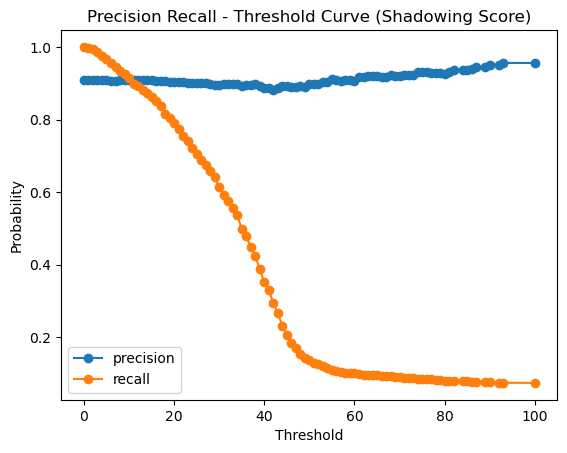

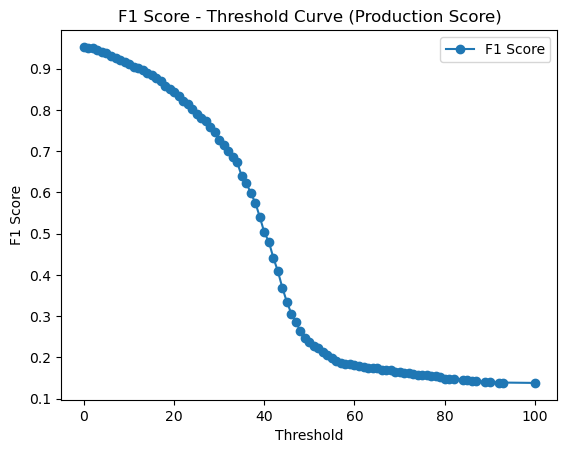

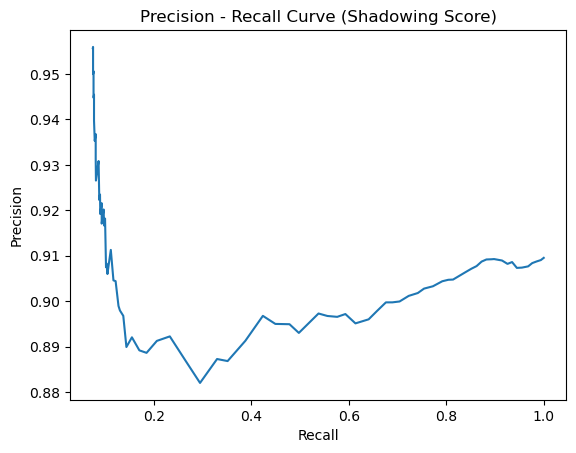

In [56]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is shadowing model for detecting unpaid cash being 1 the positive label.
prec_2, recall_2, thresholds_2 = precision_recall_curve(df['unpaid'].values, df['shadowing_score'].values, pos_label=1)
f1_scores_2 = 2 * (prec_2* recall_2) / (prec_2 + recall_2)

plt.plot(thresholds_2[:], prec_2[:-1], label='precision', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Shadowing Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_2[:], f1_scores_2[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")


plt.figure()

plt.plot(recall_2[:-1], prec_2[:-1])
plt.title("Precision - Recall Curve (Shadowing Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

# Model comparison

In [57]:
# Convert payment_status to binary where NOT_PAID is 1 and PAID is 0
df['true_label'] = df['unpaid']

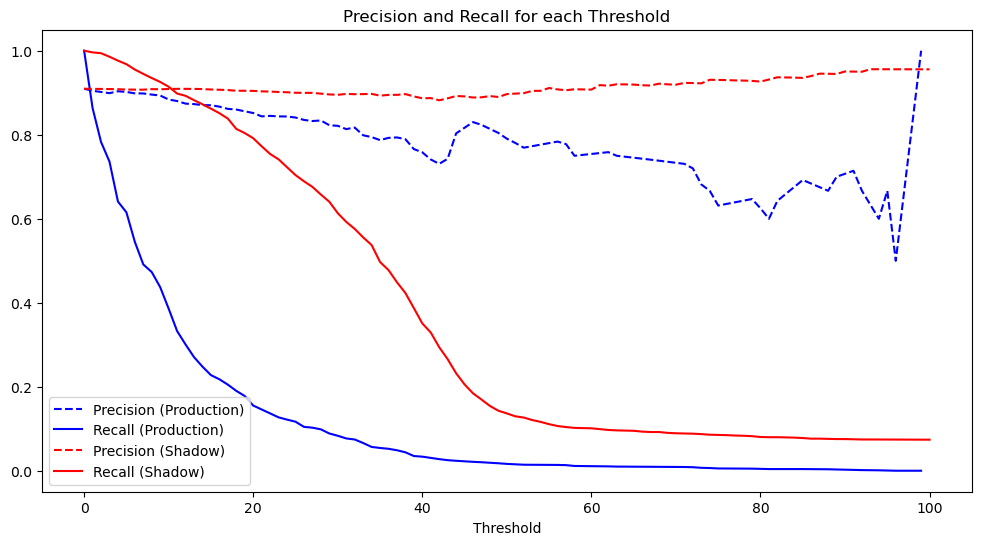

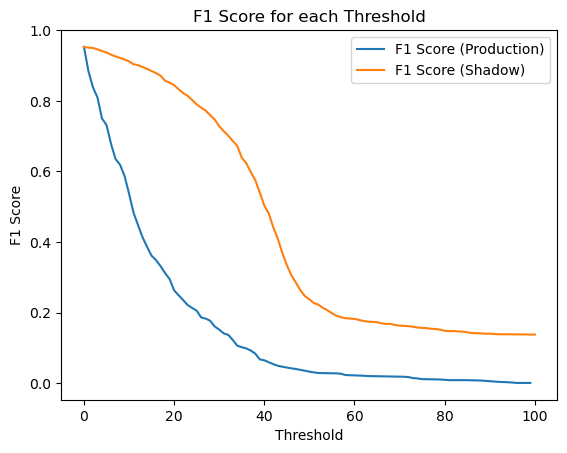

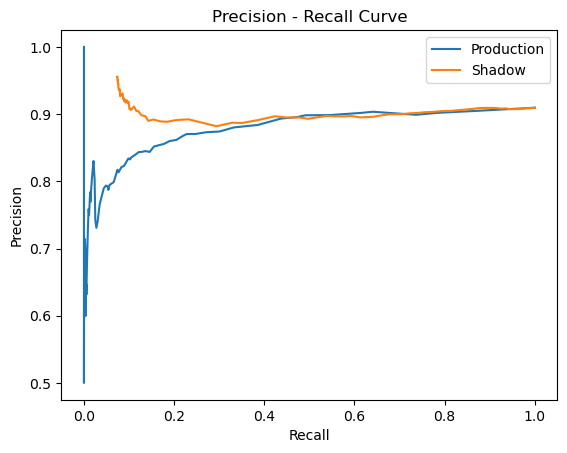

In [58]:
# Calculate precision, recall, and thresholds for each model
precision_production, recall_production, thresholds_production = precision_recall_curve(df['true_label'], df['production_score'])
precision_shadow, recall_shadow, thresholds_shadow = precision_recall_curve(df['true_label'], df['shadowing_score'])

f1_production = 2 * (precision_production* recall_production) / (precision_production + recall_production)
f1_shadow = 2 * (precision_shadow* recall_shadow) / (precision_shadow + recall_shadow)

# Plot precision and recall against the threshold for each model
plt.figure(figsize=(12, 6))

plt.plot(thresholds_production, precision_production[:-1], 'b--', label='Precision (Production)')
plt.plot(thresholds_production, recall_production[:-1], 'b-', label='Recall (Production)')
plt.plot(thresholds_shadow, precision_shadow[:-1], 'r--', label='Precision (Shadow)')
plt.plot(thresholds_shadow, recall_shadow[:-1], 'r-', label='Recall (Shadow)')
plt.xlabel('Threshold')
plt.title('Precision and Recall for each Threshold')
plt.legend()

plt.figure()

plt.plot(thresholds_production, f1_production[:-1], label='F1 Score (Production)')
plt.plot(thresholds_shadow, f1_shadow[:-1], label='F1 Score (Shadow)')
plt.legend()
plt.title("F1 Score for each Threshold")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_production[:-1], precision_production[:-1], label="Production")
plt.plot(recall_shadow[:-1], precision_shadow[:-1], label="Shadow")
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()  # This line will display the labels
plt.show()


plt.show()

# ROC Curves with AUC

Thresholds: [inf 99. 96. 95. 94. 91. 89. 88. 85. 81. 79. 75. 74. 73. 72. 62. 58. 57.
 56. 52. 50. 49. 47. 46. 44. 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33.
 32. 31. 30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15.
 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]
AUC: 0.41892741711394177


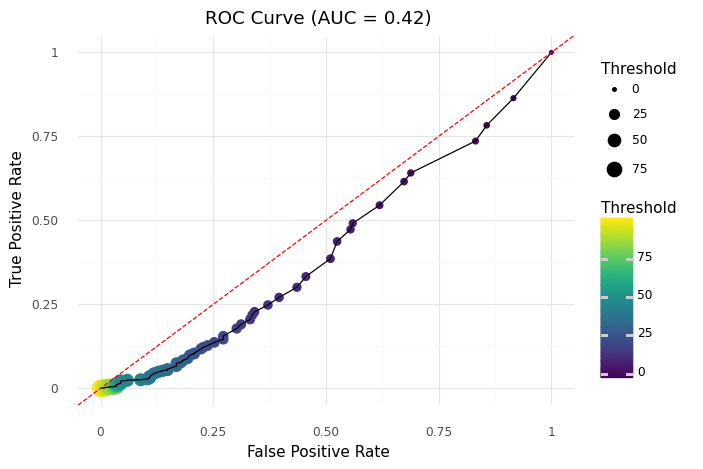

<ggplot: (401379817)>

In [59]:
# Production model
plot_roc_curve(df, preds_col='production_score', label_col='unpaid')

Thresholds: [ inf 100.  93.  92.  90.  89.  87.  86.  85.  82.  81.  80.  79.  78.
  77.  76.  74.  73.  72.  71.  70.  69.  68.  67.  66.  65.  63.  62.
  61.  60.  58.  57.  56.  55.  54.  53.  52.  51.  50.  49.  48.  47.
  46.  45.  44.  43.  42.  41.  40.  39.  38.  37.  36.  35.  34.  33.
  32.  31.  30.  29.  28.  27.  26.  25.  24.  23.  22.  21.  20.  19.
  18.  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.   6.   5.
   4.   3.   2.   1.   0.]
AUC: 0.4457493016657648


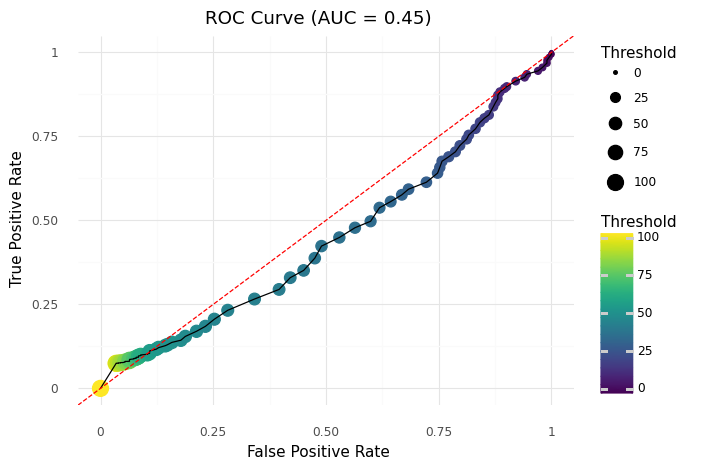

<ggplot: (401405057)>

In [60]:
# Shadowing Model
plot_roc_curve(df, preds_col='shadowing_score', label_col='unpaid')